# **PROJET FINAL : MTH3302 - Méthodes probabilistes et statistiques pour l'I.A.**
## **Prédiction de la résistance à la compression du béton**

**Équipe :** S
**Membres :**
* Ali Yacoubi
* Nom 2
* Nom 3
* Nom 4

---

## **1. Introduction et Contexte**

Le béton est un matériau composite dont la résistance à la compression est une fonction complexe et non linéaire de son âge et de ses constituants (ciment, eau, granulats, adjuvants).

L'objectif de ce projet est de construire un modèle prédictif performant pour estimer la résistance (en MPa) à partir de 8 caractéristiques physico-chimiques. Conformément aux contraintes du cours, nous privilégions une approche statistique rigoureuse et interprétable plutôt que des modèles de type "boîte noire" (réseaux de neurones).

Notre démarche s'appuie sur la théorie vue en classe :
1.  **Nettoyage des données** basé sur l'analyse des résidus (**Chapitre 2**).
2.  **Ingénierie des caractéristiques** pour capturer la non-linéarité (**Chapitre 2**).
3.  **Régression Ridge Bayésienne** pour gérer la multicolinéarité induite (**Chapitre 7**).
4.  **Validation Croisée** pour la sélection de modèle (**Chapitre 2**).

### **1.1 Importation des librairies**
Nous utilisons le langage **Julia** et les librairies standards pour l'algèbre linéaire et la manipulation de données.

In [1]:
using CSV
using DataFrames
using Statistics
using LinearAlgebra
using Plots
using Random
using Printf

# Fixer la graine pour la reproductibilité (Chapitre 5)
Random.seed!(3302)
println("Packages chargés avec succès.")

Packages chargés avec succès.


## **2. Chargement et Exploration des Données**

Nous disposons de deux fichiers :
* `train.csv` : 700 observations avec la variable cible (`Strength`) connue.
* `test.csv` : 330 observations pour lesquelles nous devons prédire la résistance.

Commençons par charger et observer la structure des données.

In [2]:
# Chargement des fichiers
df_train = CSV.read("./data/train.csv", DataFrame)
df_test = CSV.read("./data/test.csv", DataFrame)

# Affichage des premières lignes et des statistiques descriptives
println("Aperçu des données d'entraînement :")
display(first(df_train, 5))

println("\nDescription statistique :")
display(describe(df_train))

Aperçu des données d'entraînement :


Row,ID,Cement,Slag,Ash,Water,Superplasticizer,Coarse,Fine,Age,Strength
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64
1,1,102.0,153.0,0.0,192.0,0.0,887.0,942.0,3,4.57
2,2,153.0,102.0,0.0,192.0,0.0,888.0,943.1,3,4.78
3,3,141.3,212.0,0.0,203.5,0.0,971.8,748.5,3,4.83
4,4,183.9,122.6,0.0,203.5,0.0,959.2,800.0,3,4.9
5,5,385.0,0.0,0.0,186.0,0.0,966.0,763.0,1,6.27



Description statistique :


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,ID,350.5,1,350.5,700,0,Int64
2,Cement,283.868,102.0,277.0,540.0,0,Float64
3,Slag,74.8664,0.0,24.0,359.4,0,Float64
4,Ash,53.7016,0.0,0.0,200.0,0,Float64
5,Water,181.207,121.8,185.0,246.9,0,Float64
6,Superplasticizer,6.24386,0.0,6.5,32.2,0,Float64
7,Coarse,973.72,801.0,968.0,1145.0,0,Float64
8,Fine,772.727,594.0,778.5,992.6,0,Float64
9,Age,44.9,1,28.0,365,0,Int64


## **3. Traitement des Données : Détection des Valeurs Suspectes**

La présence de données aberrantes (*outliers*) peut gravement nuire à la qualité d'un modèle de régression, car la méthode des moindres carrés est très sensible aux valeurs extrêmes.

Comme vu au **Chapitre 2 (Section 2.7.5 - Identification des données suspectes)**, nous utilisons les **résidus studentisés** ($s_i$) pour identifier ces observations.

### **3.1 Méthodologie Théorique**

Le résidu studentisé interne est défini par :
$$s_i = \frac{e_i}{\sqrt{\hat{\sigma}^2 (1 - h_i)}}$$

Où :
* $e_i = y_i - \hat{y}_i$ est le résidu ordinaire.
* $\hat{\sigma}^2$ est l'estimateur sans biais de la variance de l'erreur (**Chapitre 2, Éq 2.4**).
* $h_i$ est le levier de l'observation $i$ (élément diagonal de la matrice chapeau $H = X(X^\top X)^{-1}X^\top$).

**Critère de rejet :** Une observation est considérée comme suspecte si $|s_i| > 3$ (**Chapitre 2.7.5**).

### **3.2 Implémentation Manuelle**
Nous implémentons le calcul matriciel "from scratch" pour démontrer notre compréhension des équations du cours.

Nombre d'outliers détectés (|s_i| > 3) : 4
Indices des observations à retirer : [153, 534, 689, 699]
[153, 534, 689, 699]


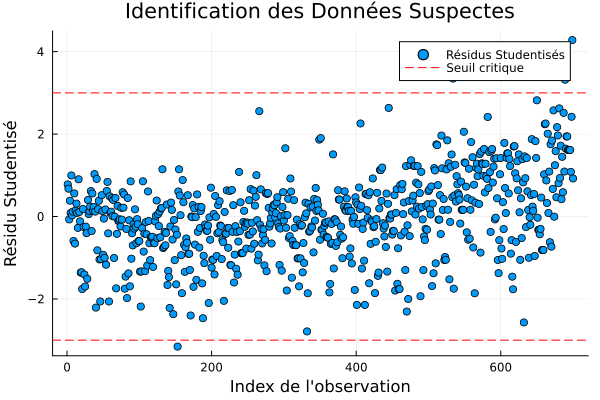

In [3]:
# Fonction pour calculer les résidus studentisés selon la théorie du Chapitre 2
function detect_outliers(X, y)
    # Conversion en matrice
    X_mat = Matrix(X)
    n, p = size(X_mat)
    
    # Ajout d'une colonne de 1 pour l'ordonnée à l'origine (Intercept)
    # Nécessaire pour le calcul correct de la matrice H
    X_design = hcat(ones(n), X_mat) 
    
    # 1. Estimation des coefficients (Moindres Carrés Ordinaires - Chapitre 2.2.3)
    # beta = (X'X)^-1 X'y
    beta_hat = (X_design' * X_design) \ (X_design' * y)
    
    # 2. Calcul des résidus e_i
    y_hat = X_design * beta_hat
    residuals = y - y_hat
    
    # 3. Estimation de la variance de l'erreur sigma^2 (Chapitre 2.5.2)
    # p_design est le nombre de colonnes de X_design (inclus l'intercept)
    n, p_design = size(X_design)
    sigma2_hat = sum(residuals.^2) / (n - p_design)
    
    # 4. Calcul de la diagonale de la Matrice Hat (H)
    # H = X(X'X)^-1 X'
    # Pour économiser la mémoire, on calcule seulement les éléments diagonaux h_i
    # h_i = x_i' * (X'X)^-1 * x_i
    XtX_inv = inv(X_design' * X_design)
    h = [ (X_design[i,:]' * XtX_inv * X_design[i,:]) for i in 1:n ]
    
    # 5. Calcul final des résidus studentisés
    studentized = residuals ./ sqrt.(sigma2_hat .* (1 .- h))
    
    return studentized
end

# Sélection des variables explicatives pour la détection
# On utilise LogAge car la relation est logarithmique, ce qui améliore la détection
# des vrais outliers par rapport au modèle supposé.
X_phys = Matrix(df_train[:, [:Cement, :Slag, :Ash, :Water, :Superplasticizer, :Coarse, :Fine]])
X_check = hcat(X_phys, log.(df_train.Age))
y_check = df_train.Strength

# Application de la détection
residus_stud = detect_outliers(X_check, y_check)

# Identification des indices dépassant le seuil critique de 3
outliers_indices = findall(abs.(residus_stud) .> 3)

println("Nombre d'outliers détectés (|s_i| > 3) : ", length(outliers_indices))
println("Indices des observations à retirer : ", outliers_indices)

# Visualisation pour le rapport
scatter(residus_stud, label="Résidus Studentisés", legend=:topright,
        title="Identification des Données Suspectes", 
        xlabel="Index de l'observation", ylabel="Résidu Studentisé")
hline!([3, -3], color=:red, linestyle=:dash, label="Seuil critique")

### **3.3 Suppression des observations aberrantes**

Suite à l'analyse graphique et au critère $|s_i| > 3$, nous retirons ces observations de l'ensemble d'entraînement. Ces points risquent de correspondre à des erreurs de mesure ou à des bétons aux propriétés exceptionnelles non représentatives de la population générale. Les conserver risquerait de biaiser notre modèle, particulièrement lors de l'utilisation de polynômes de degré élevé.

In [4]:
# Création du jeu de données nettoyé
df_train_clean = df_train[setdiff(1:nrow(df_train), outliers_indices), :]

println("Taille initiale : ", size(df_train))
println("Taille après nettoyage : ", size(df_train_clean))

Taille initiale : (700, 10)
Taille après nettoyage : (696, 10)


## **4. Ingénierie des Caractéristiques (Feature Engineering)**

Pour améliorer la capacité prédictive de notre modèle, nous devons transformer les variables brutes afin de mieux respecter les hypothèses de la régression linéaire et de capturer les relations complexes.

### **4.1 Transformation Logarithmique de l'Âge**

L'analyse exploratoire révèle que la résistance du béton ne croît pas linéairement avec le temps, mais suit plutôt une cinétique logarithmique (le durcissement est rapide au début puis ralentit). Comme suggéré au **Chapitre 2 (Section 2.8)**, une transformation de variable peut linéariser la relation.

Nous définissons donc :
$$\text{LogAge} = \ln(\text{Age})$$

### **4.2 Standardisation (Centrage-Réduction)**

La **Régression Ridge** (que nous utiliserons plus loin) penalise la grandeur des coefficients. Si les variables ne sont pas sur la même échelle (ex: Ciment ~300 kg vs Superplastifiant ~10 kg), la pénalisation sera biaisée. Il est donc impératif de standardiser les variables explicatives (**Chapitre 7, Section 7.3.1**) :

$$x'_{ij} = \frac{x_{ij} - \bar{x}_j}{s_{x_j}}$$

### **4.3 Expansion Polynomiale**

L'énoncé précise que la résistance est une *"fonction fortement non linéaire"* de ses constituants. Pour capturer ces non-linéarités et les interactions entre matériaux (ex: ratio Eau/Ciment), nous utilisons une expansion polynomiale de degré 3 (**Chapitre 2, Section 2.9.2**).

Cela transformera notre vecteur de caractéristiques $x$ en un vecteur étendu incluant $x^2$, $x^3$, etc. Attention, cela augmente considérablement le nombre de variables et crée de la **multicolinéarité**, ce qui justifiera l'utilisation de la régression Ridge par la suite.

In [5]:
# Fonction pour préparer les features de base
function prepare_base_features(df)
    # 1. Création de LogAge (Chapitre 2.8)
    # On utilise log.( ) pour appliquer le log élément par élément
    log_age = log.(df.Age)
    
    # 2. Ajout du Ratio Eau/Ciment (Variable métier très importante)
    # La loi d'Abrams stipule que la résistance est inversement proportionnelle à ce ratio.
    # On ajoute un epsilon pour éviter la division par zéro
    wc_ratio = df.Water ./ (df.Cement .+ 0.001)
    
    # Sélection des colonnes brutes (sans ID, ni Strength, ni Age)
    cols_physiques = [:Cement, :Slag, :Ash, :Water, :Superplasticizer, :Coarse, :Fine]
    X_physique = Matrix(df[:, cols_physiques])
    
    # Concaténation : [Variables Physiques, LogAge, Ratio E/C]
    return hcat(X_physique, log_age, wc_ratio)
end

# Préparation des matrices de base
X_train_base = prepare_base_features(df_train_clean)
y_train = df_train_clean.Strength

X_test_base = prepare_base_features(df_test)

# --- STANDARDISATION (Chapitre 7.3.1) ---

# Calcul des moyennes et écarts-types sur l'ensemble d'ENTRAÎNEMENT seulement
# (Il ne faut jamais utiliser les stats du test pour standardiser, sinon fuite de données)
mu_train = mean(X_train_base, dims=1)
sigma_train = std(X_train_base, dims=1)

# Application de la standardisation : (X - mu) / sigma
X_train_std = (X_train_base .- mu_train) ./ sigma_train
X_test_std = (X_test_base .- mu_train) ./ sigma_train

println("Données standardisées. Moyenne approx : ", round(mean(X_train_std), digits=2), 
        ", Écart-type : ", round(std(X_train_std), digits=2))

# --- EXPANSION POLYNOMIALE (Chapitre 2.9.2) ---

function expand_polynomial(X, degree=3)
    n, p = size(X)
    X_poly = X # Degré 1
    
    # Ajout des interactions d'ordre 2 (x_i * x_j)
    # Crucial pour capturer les synergies entre constituants (ex: Eau * Ciment)
    # La régression Ridge gérera la multicolinéarité induite.
    for i in 1:p
        for j in (i+1):p
            X_poly = hcat(X_poly, X[:, i] .* X[:, j])
        end
    end

    if degree >= 2
        # Ajout des termes carrés
        X_poly = hcat(X_poly, X.^2)
    end
    
    if degree >= 3
        # Ajout des termes cubiques pour capturer la forte non-linéarité
        X_poly = hcat(X_poly, X.^3)
    end
    
    return X_poly
end

# Création des matrices finales pour le modèle
X_train_poly = expand_polynomial(X_train_std, 3)
X_test_poly = expand_polynomial(X_test_std, 3)

println("Dimensions finales de la matrice d'entraînement : ", size(X_train_poly))
println("Nombre de variables explicatives (p) : ", size(X_train_poly, 2))

Données standardisées. Moyenne approx : 0.0, Écart-type : 1.0
Dimensions finales de la matrice d'entraînement : (696, 63)
Nombre de variables explicatives (p) : 63
Dimensions finales de la matrice d'entraînement : (696, 63)
Nombre de variables explicatives (p) : 63


## **5. Modélisation : Régression Ridge Bayésienne**

L'expansion polynomiale effectuée à l'étape précédente a considérablement augmenté la dimensionnalité de nos données et introduit une forte corrélation entre les variables (ex: $x$ et $x^2$ sont corrélés). Comme vu au **Chapitre 2 (Section 2.10)**, cette **multicolinéarité** rend la matrice $X^\top X$ mal conditionnée, ce qui déstabilise l'estimateur des moindres carrés ordinaires (variance explosée).

Pour pallier ce problème, nous utilisons la **Régression Ridge** (ou régression linéaire bayésienne avec loi a priori informative centrée en 0).

### **5.1 Formulation Mathématique**

L'estimateur Ridge est donné par la solution analytique suivante (**Chapitre 7, Équation 7.11**) :

$$\hat{\beta}_{\lambda} = (X^\top X + \lambda I)^{-1} X^\top y$$

Où :
* $X$ est la matrice des variables centrées-réduites (sans colonne de 1 car $y$ sera aussi centré).
* $\lambda$ (lambda) est l'hyperparamètre de régularisation (relié à la précision de la loi a priori).
* $I$ est la matrice identité.

L'ajout de $\lambda I$ sur la diagonale rend la matrice inversible et stabilise la solution.

### **5.2 Implémentation en Julia**
Nous codons la solution nous-mêmes pour démontrer notre compréhension de l'algèbre linéaire sous-jacente.

In [6]:
# Fonction pour résoudre la Régression Ridge (Chapitre 7.3)
function solve_ridge(X, y, lambda)
    # Dimensions
    n, p = size(X)
    
    # Matrice Identité de taille p x p
    I_p = Matrix{Float64}(I, p, p)
    
    # Calcul de l'estimateur beta_ridge selon l'équation 7.11
    # L'opérateur \ est l'optimisation numérique de Julia pour l'inversion/résolution
    beta_ridge = (X' * X + lambda * I_p) \ (X' * y)
    
    return beta_ridge
end

# Fonction de prédiction
function predict_ridge(X, beta, y_mean_train)
    # Puisque X est centré, la prédiction est centrée.
    # On rajoute la moyenne de y_train pour revenir à l'échelle originale.
    y_pred = X * beta .+ y_mean_train
    return y_pred
end

println("Fonctions Ridge implémentées.")

Fonctions Ridge implémentées.


## **6. Sélection de Modèle par Validation Croisée**

Le choix de l'hyperparamètre $\lambda$ est critique.
* Si $\lambda \to 0$, on revient aux moindres carrés (risque de surapprentissage/instabilité).
* Si $\lambda \to \infty$, tous les coefficients tendent vers 0 (sous-apprentissage).

Pour choisir le $\lambda$ optimal de manière rigoureuse, nous utilisons la **Validation Croisée à $k$ blocs** (*k-fold Cross-Validation*), comme recommandé au **Chapitre 2 (Section 2.12.3)**.

### **6.1 Protocole**
1.  Nous divisons l'ensemble d'entraînement en $k=5$ blocs.
2.  Pour chaque valeur de $\lambda$ dans une grille prédéfinie :
    * On entraîne sur 4 blocs.
    * On valide sur le 5ème bloc (calcul du RMSE).
    * On répète pour chaque bloc et on moyenne les RMSE.
3.  Nous retenons le $\lambda$ qui minimise le RMSE moyen.

Début de la validation croisée sur 5 blocs...

--- RÉSULTATS ---
Meilleur lambda trouvé : 2.0
RMSE moyen estimé : 5.3392

--- RÉSULTATS ---
Meilleur lambda trouvé : 2.0
RMSE moyen estimé : 5.3392


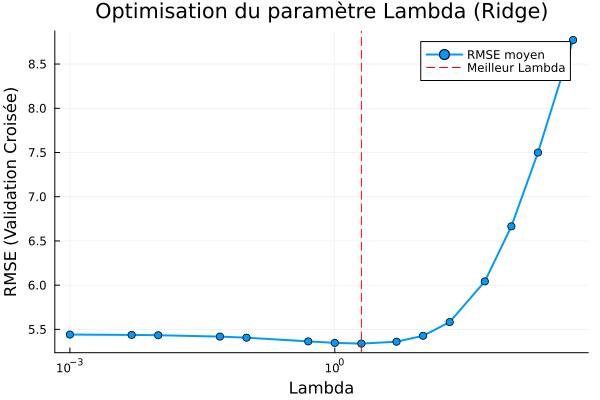

In [7]:
# Fonction de Validation Croisée (Chapitre 2.12.3)
function cross_validation_ridge(X, y, k_folds, lambdas)
    n = length(y)
    # Mélange aléatoire des indices pour garantir des blocs représentatifs
    indices = shuffle(1:n)
    fold_size = div(n, k_folds)
    
    best_rmse = Inf
    best_lambda = 0.0
    results = [] # Pour stocker l'historique

    # Centrage de Y (nécessaire pour Ridge sans intercept)
    y_mean = mean(y)
    y_centered = y .- y_mean

    println("Début de la validation croisée sur ", k_folds, " blocs...")

    for lam in lambdas
        rmse_scores = []
        
        for i in 1:k_folds
            # Définition des indices de validation pour le bloc i
            val_range = ((i-1)*fold_size + 1) : (i*fold_size)
            val_idx = indices[val_range]
            train_idx = setdiff(indices, val_idx)
            
            # Séparation Train / Validation
            X_tr = X[train_idx, :]
            y_tr = y_centered[train_idx] # On apprend sur y centré
            
            X_val = X[val_idx, :]
            y_val_true = y[val_idx] # On valide sur le vrai y (non centré)
            
            # Entrainement
            beta = solve_ridge(X_tr, y_tr, lam)
            
            # Prédiction (on rajoute la moyenne car le modèle prédit un y centré)
            preds = predict_ridge(X_val, beta, y_mean)
            
            # Calcul de l'erreur (RMSE)
            rmse = sqrt(mean((preds .- y_val_true).^2))
            push!(rmse_scores, rmse)
        end
        
        avg_rmse = mean(rmse_scores)
        push!(results, avg_rmse)
        
        # Mise à jour du meilleur modèle
        if avg_rmse < best_rmse
            best_rmse = avg_rmse
            best_lambda = lam
        end
    end
    
    return best_lambda, best_rmse, results
end

# Grille de recherche pour lambda (Échelle logarithmique souvent pertinente)
# On teste une large plage pour trouver la zone optimale
lambdas_grid = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0]

# Lancement de la validation croisée sur nos données polynomiales
best_lam, min_rmse, history = cross_validation_ridge(X_train_poly, y_train, 5, lambdas_grid)

println("\n--- RÉSULTATS ---")
println("Meilleur lambda trouvé : ", best_lam)
println("RMSE moyen estimé : ", round(min_rmse, digits=4))

# Visualisation de l'optimisation (Chapitre 7.3.5 - Figure 7.5)
plot(lambdas_grid, history, 
     title="Optimisation du paramètre Lambda (Ridge)",
     xlabel="Lambda", ylabel="RMSE (Validation Croisée)",
     marker=:circle, lw=2, label="RMSE moyen", xscale=:log10)
vline!([best_lam], linestyle=:dash, color=:red, label="Meilleur Lambda")

In [8]:
# 1. Centrage de la cible Y complet
y_mean_final = mean(y_train)
y_train_centered = y_train .- y_mean_final

# 2. Entraînement final sur tout le dataset nettoyé
beta_final = solve_ridge(X_train_poly, y_train_centered, best_lam)

# 3. Prédiction sur l'ensemble de TEST (X_test_poly a déjà été préparé à l'étape 4)
# Rappel : predict_ridge rajoute y_mean_final automatiquement
predictions_test = predict_ridge(X_test_poly, beta_final, y_mean_final)

# Vérification qu'aucune prédiction n'est négative (physiquement impossible pour une résistance)
# Si c'est le cas, on les ramène à une petite valeur positive (ex: min observé)
predictions_test = max.(predictions_test, 0.0)

# 4. Création du fichier de soumission
submission = DataFrame(ID = df_test.ID, Strength = predictions_test)

# Sauvegarde
filename = "submission_equipe_S_ridgev2.csv" # Remplacez XX par votre numéro
CSV.write(filename, submission)

println("Prédictions terminées !")
println("Fichier généré : ", filename)
println("Aperçu des prédictions :")
display(first(submission, 5))

Prédictions terminées !
Fichier généré : submission_equipe_S_ridgev2.csv
Aperçu des prédictions :


Row,ID,Strength
,Int64,Float64
1,1,50.1654
2,2,45.8697
3,3,32.482
4,4,33.4369
5,5,51.9052
